<a href="https://www.kaggle.com/code/hermengardo/ps6e2-eda-ensembling?scriptVersionId=297528614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Imports</h1>
</div>

In [1]:
!pip install hillclimbers -q

  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import re
import seaborn as sns
import warnings
import optuna
import logging

from catboost import CatBoostClassifier
from hillclimbers import climb_hill, partial
from lightgbm import LGBMClassifier
from matplotlib.patches import Patch
from rich.console import Console
from sklearn.cluster import KMeans
from itertools import combinations, permutations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.base import clone
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
rc = {
    "axes.facecolor": "#fff",
    "axes.edgecolor": "#0e0e0e",
    "figure.facecolor": "#fff",
    "grid.color": "#0e0e0e",
    "axes.grid": True,
    
    "grid.linestyle":"--",
    "axes.labelcolor": "#0e0e0e",
    "xtick.color": "#0e0e0e",
    "ytick.color": "#0e0e0e",
    "legend.labelcolor": "#0e0e0e",
    "legend.edgecolor": "#fff",
    "patch.edgecolor": "#0B90A7",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.size": 18,
    "font.family": "serif",
    "font.weight": "bold",
    "grid.alpha": 0.1,
}

props = {
    'boxprops': {'edgecolor': '#0e0e0e', 'alpha': 1},
    'medianprops': {'color': '#0e0e0e', 'linestyle': '-', 'linewidth': 0.7},
    'whiskerprops': {'color': '#0e0e0e', 'linestyle': '--', 'linewidth': 0.7},
    'capprops': {'color': '#0e0e0e', 'linewidth': 0.7},
    'flierprops': {'marker': 'o', 'markersize': 4, 'markerfacecolor': 'none', 'markeredgecolor': '#0e0e0e', 'markerfacecolor': '#fffdf7', 'linewidth': 0.7}
}

sns.set(rc=rc)

sns.despine()

<Figure size 640x480 with 0 Axes>

In [4]:
class settings():
    target:           str      = "Heart Disease"
    identifier:       str|None = "id"

    shuffle:          bool     = True
    splits:           int      = 15
    seed:             int      = 9182

cfg = settings()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Loading</h1>
</div>

In [5]:
def read_data(directory:str) -> tuple:
    """
        Read CSV files from a directory and return train, test, and submission DataFrames.
    """
    data = {}
    for filename in os.listdir(directory):
        key = re.search("(.*).csv", filename).group(1)
        data[key] = pd.read_csv(
            os.path.join(
                directory, 
                filename
            )
        )
    
    train = data["train"]
    test  = data["test"]
    sub   = data["sample_submission"]
        
    return train, test, sub

In [6]:
train, test, sub = read_data("/kaggle/input/playground-series-s6e2")

train["Heart Disease"] = train["Heart Disease"].replace({
    "Presence":1,
    "Absence":0
}).astype(int).copy()

train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Exploratory Data Analysis">
    ✨ EDA
  </h1>
</div>
     
* **Main takeaways:**
  1. Heart Disease is **highly correlated** with Chest pain type and Thalium.
  2. Chest pain of **type 4** is correlated with the presence of Heart Disease.
  3. Chest pain of **types 1, 2, and 3** is correlated with the absence of Heart Disease.
  4. Highly **imbalanced data** on FBS over 120 (92% of the data comes from the same category)
  6. **Older people** are more likely to have Heart Disease (no surprises, I guess)

In [7]:
def ridgeline(df, x, row, title, xlabel, pallete="viridis"):
    """
    Given a DataFrame, a target column, and a categorical variable used for
    aggregation, this function produces a kde ridgeplot.
    
    See:
    https://seaborn.pydata.org/examples/kde_ridgeplot
    """
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0), "axes.grid": False})
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=8, height=2, palette=pallete)
    g.map(sns.kdeplot, x, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=2.5)
    g.map(sns.kdeplot, x, clip_on=False, color="black", lw=2.5, bw_adjust=.5)
    g.refline(y=0, linewidth=2.5, linestyle="-", color="black", clip_on=False)

    def label(x, color, label):
        plt.gca().text(0, .2, label, fontweight="bold",
                       color=color, ha="left",
                       va="center", transform=plt.gca().transAxes)

    g.map(label, x)
    g.figure.suptitle(title, fontsize=16, fontweight="bold", y=1.05)
    g.set_xlabels(xlabel)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

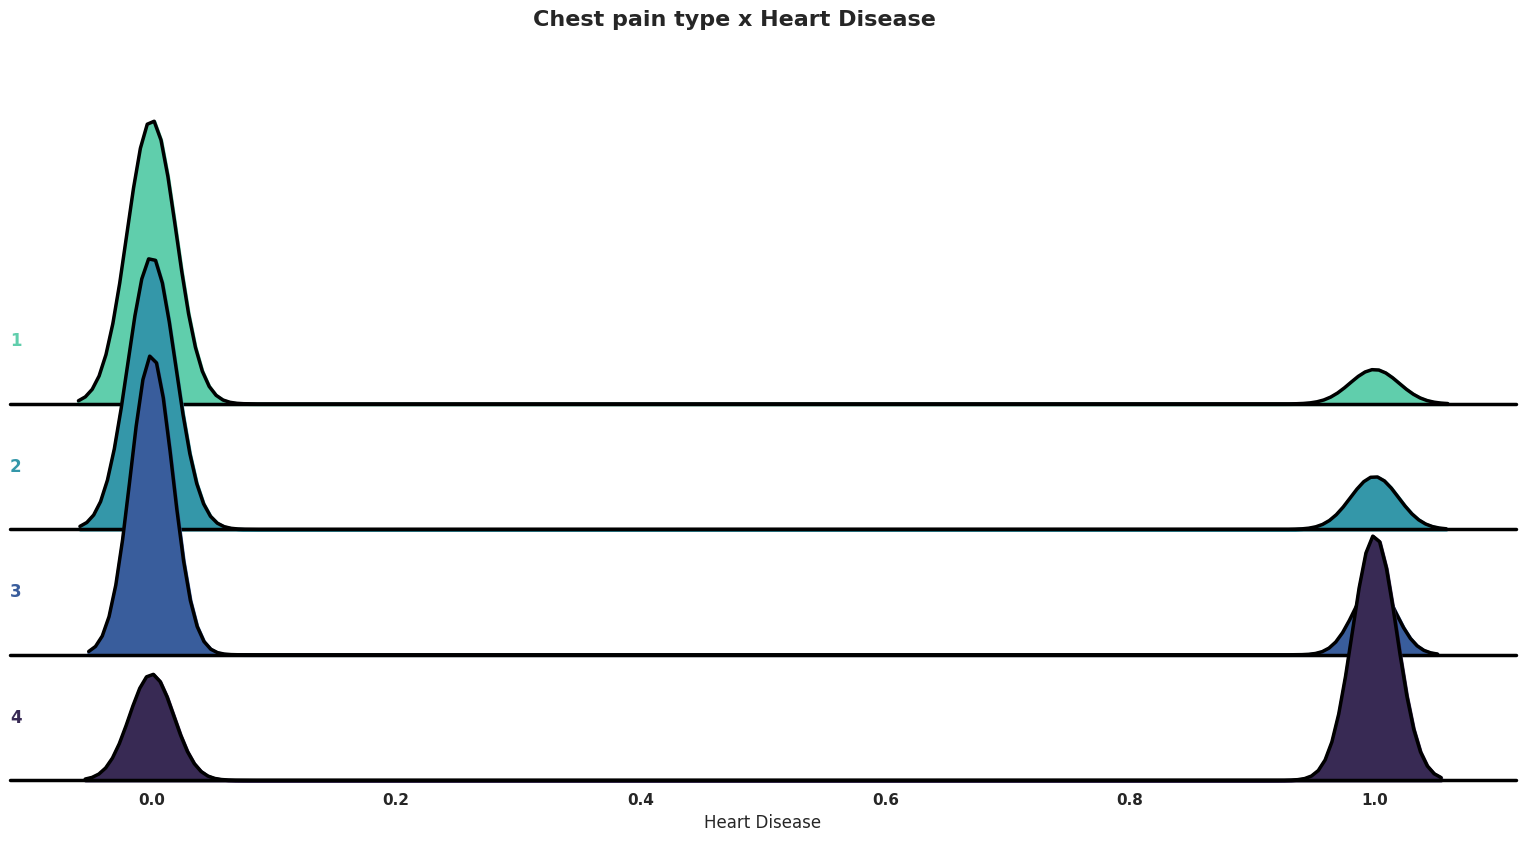

In [8]:
ridgeline(
    train,
    x="Heart Disease",
    row="Chest pain type",
    title=f"Chest pain type x Heart Disease",
    xlabel="Heart Disease",
    pallete="mako_r"
)

sns.set(rc=rc)

In [9]:
def plot_box(df, target, cols=3, colors=['#0B90A7','#E63946', '#E9C46A'], figsize=(15, 8), y_title=None, title=None, props=props):
    columns = df.select_dtypes('int').columns
    rows = np.ceil(len(columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    yt_labels = []
    for i, x in enumerate(columns):
        if x == target:
            continue
            
        current_ax = ax[i // cols, i % cols]
        sns.boxplot(data=df, y=target, ax=current_ax, x=x, orient='h', palette=colors, **props)
        current_ax.set_xlabel(x)
        
        if y_title and i % cols == 0:
            if len(yt_labels) == 0:
                yt_labels = [label.get_text() for label in current_ax.get_yticklabels()]
            current_ax.set_ylabel(y_title)
            current_ax.set_yticklabels(yt_labels)
        else:
            current_ax.set_ylabel('')
            current_ax.set_yticklabels('')
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(columns) - 1 < (rows * cols):
        for i in range(len(columns) - 1, rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Absence'),
        Patch(facecolor=colors[1], edgecolor='black', label='Presence')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .94),
        frameon=False
    )
    
    fig.tight_layout()
    plt.show()

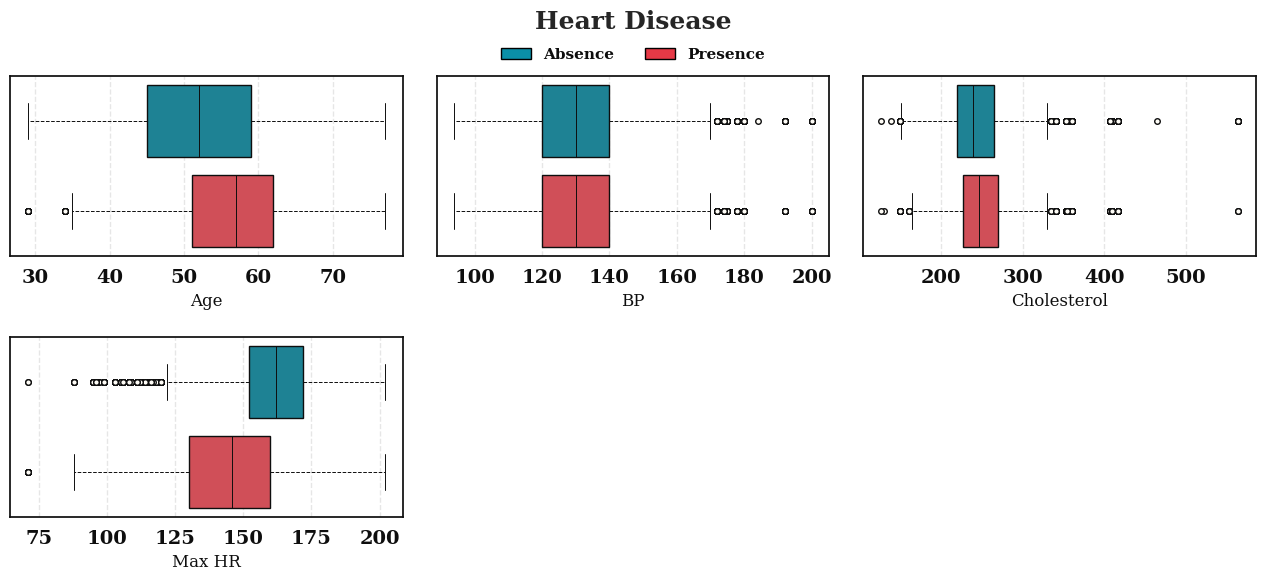

In [10]:
cat = ["id", "FBS over 120", 
       "Sex", "Chest pain type", 
       "EKG results", "Exercise angina", 
       "Slope of ST", "Number of vessels fluro", 
       "Thallium"]

plot_box(
    train.drop(cat, axis=1), 
    'Heart Disease', 
    figsize=(13, 6), 
    title='Heart Disease'
)

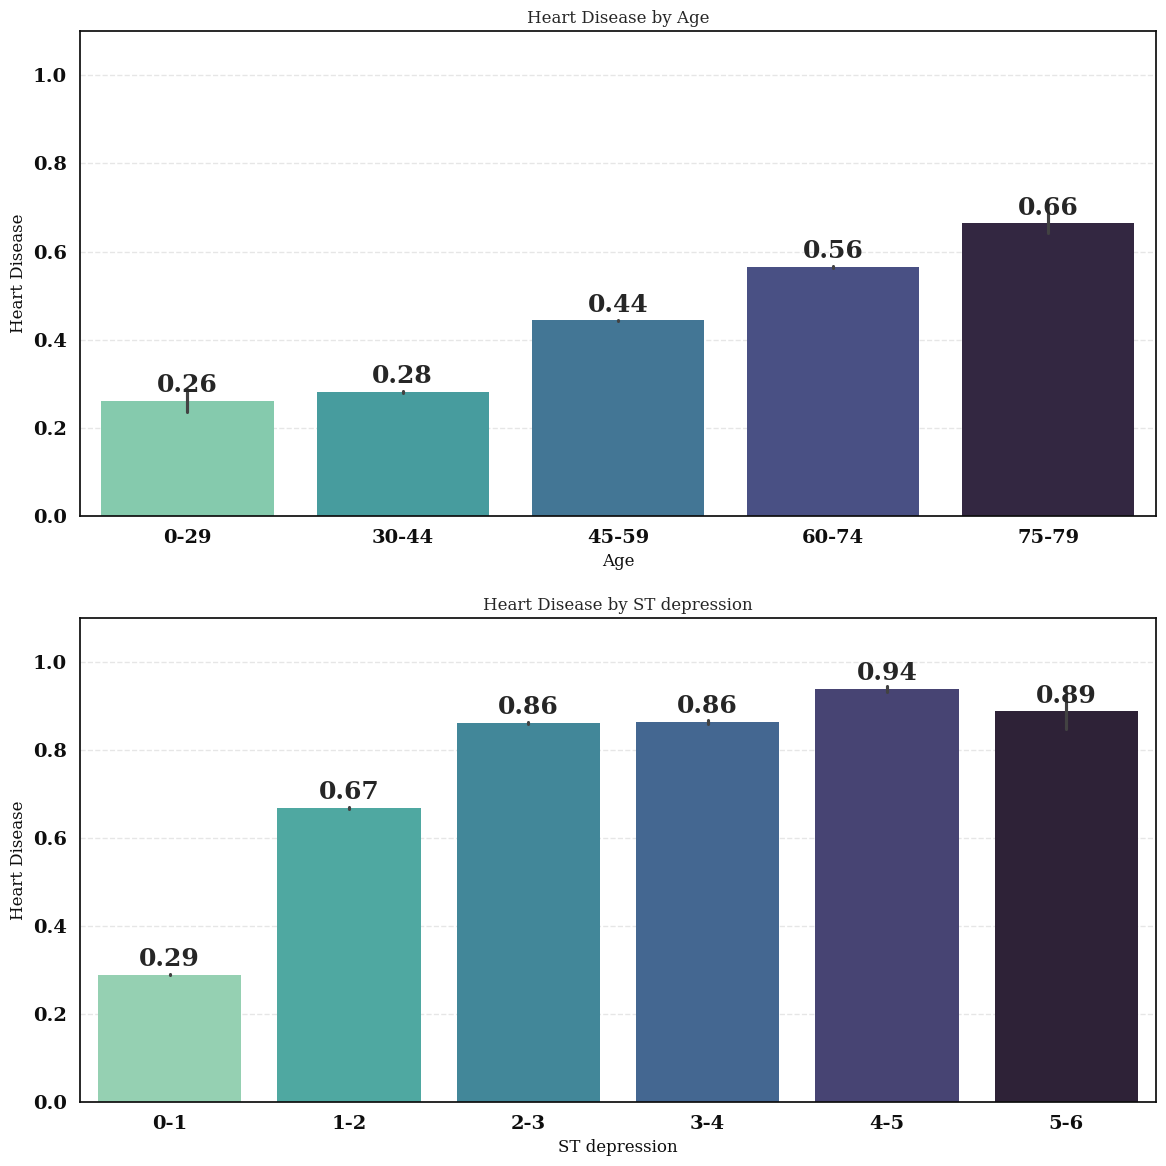

In [11]:
tmp = train.copy()

tmp['Age'] = pd.cut(tmp.Age, 
                    bins=[0, 30, 45, 60, 75, 80], 
                    labels=['0-29','30-44','45-59','60-74','75-79'], 
                    right=False)

tmp["ST depression"] = pd.cut(tmp["ST depression"], 
                    bins=[0, 1, 2, 3, 4, 5, 6], 
                    labels=['0-1','1-2','2-3','3-4','4-5', '5-6'], 
                    right=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(
    data=tmp,
    x="Age",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[0]
)

for i, v in enumerate(tmp.groupby('Age')['Heart Disease'].mean()):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[0].set_title("Heart Disease by Age")
axes[0].set_ylim(0, 1.1)

sns.barplot(
    data=tmp,
    x="ST depression",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[1]
)

for i, v in enumerate(tmp.groupby('ST depression')['Heart Disease'].mean()):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[1].set_title("Heart Disease by ST depression")
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

tmp = None

* **Main takeaways:**
    1. **Distributions look similar for both datasets**
    2. **Class 1 is almost nonexistent on EKG results**
    3. **Classes 2 and 3 of EKG results have similar proportions ~50/50**
    4. **ST depression with a heavy right tail, mostly because of the zeroes**

In [12]:
def plot_kde(df1:pd.DataFrame, 
             df2:pd.DataFrame, 
             cols:int = 3, 
             fill:bool = True, 
             figsize:tuple = (15, 12),
             colors:list = ["#0B90A7", "#E63946"], 
             title:str = None) -> None:

    df1 = df1.copy()
    df2 = df2.copy()

    df1.drop([cfg.identifier, cfg.target], axis=1, inplace=True)
    df2.drop([cfg.identifier], axis=1, inplace=True)
    
    numeric_columns = df1.select_dtypes(include='number').columns
    rows = np.ceil(len(numeric_columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, x in enumerate(numeric_columns):
        current_ax = ax[i // cols, i % cols]
        sns.kdeplot(x=x,
                    color=colors[0],
                    fill=fill,
                    data=df1,
                    label='Train',
                    ax=current_ax)
        sns.kdeplot(x=x,
                    color=colors[1],
                    fill=fill,
                    data=df2,
                    label='Test',
                    ax=current_ax)
        current_ax.set_xlabel(x)
    
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(numeric_columns) < (rows * cols):
        for i in range(len(numeric_columns), rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Train'),
        Patch(facecolor=colors[1], edgecolor='black', label='Test')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .96),
        frameon=False
    )

    fig.tight_layout()
    plt.show()

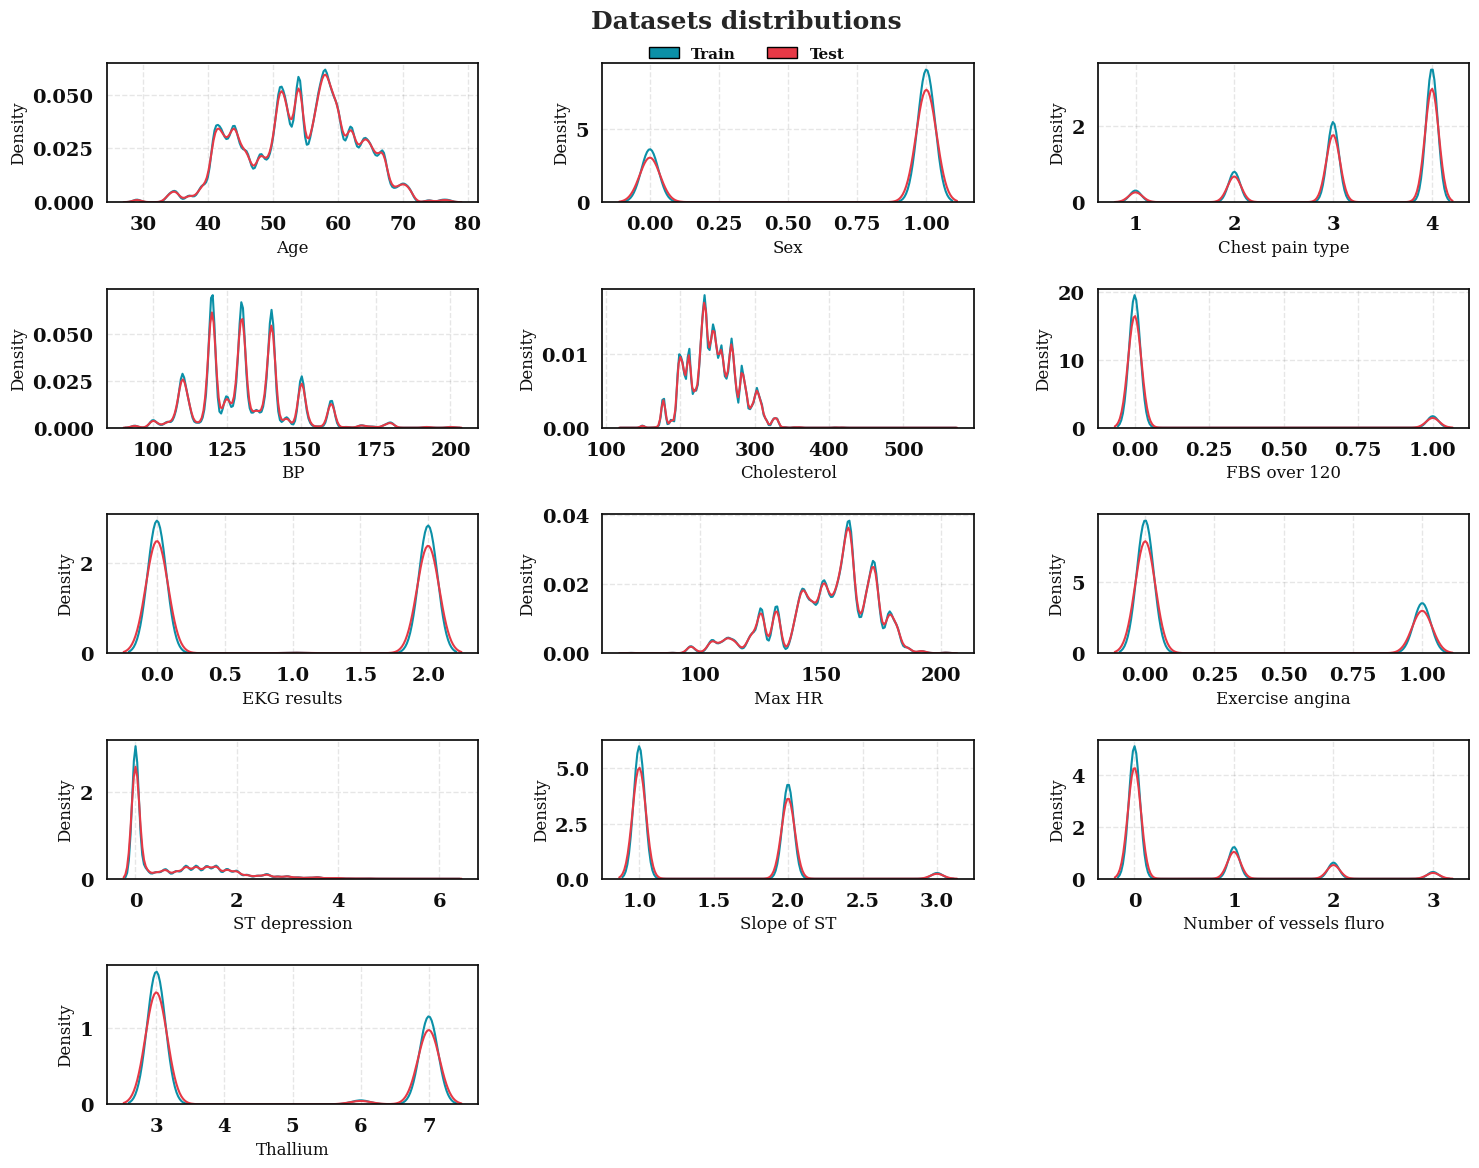

In [13]:
plot_kde(train, test, fill=False, title='Datasets distributions')

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Feature Engineering">
    ✨ Feature Engineering
  </h1>
</div>

In [14]:
X, y = train.drop(["Heart Disease", "id"], axis=1), train["Heart Disease"]

X_test = test.drop('id', axis=1)

km = KMeans(n_clusters=2, n_init='auto')
X['Cluster'] = km.fit_predict(X)

train.loc[:, 'Cluster'] = X['Cluster']
test.loc[:, 'Cluster'] = km.predict(X_test)

In [15]:
cat_cols = ["Sex", "Chest pain type", "Cluster", "FBS over 120", "EKG results", "Exercise angina", "Slope of ST", "Number of vessels fluro", "Thallium"]
num_cols = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]

In [16]:
def feature_engineering(data, num_cols, cat_cols):
    console = Console()
    initial_feature_count = data.shape[1]
    
    data = data.copy()

    for col in tqdm(cat_cols):
        agg = (
            data.groupby(col)[num_cols]
            .agg(["min", "max", "mean", "sum"])
            .reset_index()
        )
        
        agg.columns = [
            f"{col}_" + "_".join(c).strip("_") if c[0] != col else col
            for c in agg.columns.values
        ]
        
        data = data.merge(agg, on=col)

    for col in tqdm(num_cols):
        data[f"{col}_log"] = np.log1p(data[col])
        data[f"{col}_sqrt"] = np.sqrt(data[col])

    for col1, col2 in tqdm(list(combinations(num_cols, 2))):
        data[f"{col1}+{col2}"] = data[col1] + data[col2]
        data[f"{col1}*{col2}"] = data[col1] * data[col2]

    for col1, col2 in tqdm(list(permutations(num_cols, 2))):
        data[f"{col1}-{col2}"] = data[col1] - data[col2]
        data[f"{col1}/{col2}"] = (data[col1] + 1) / (data[col2] + 1) # all values are >= 0

    console.print(f"Added {data.shape[1] - initial_feature_count} features", style="bold green")
    
    return data.copy()

In [17]:
def remove_high_correlated(data, corr_threshold=0.95):
    data = data.copy()
    console = Console()
    
    corr = data.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        
    to_drop = [
        column for column in upper.columns
        if any(upper[column] > corr_threshold)
    ]
    
    console.print(f"Highly Correlated: {len(to_drop)}", style="bold red")
    
    return to_drop

In [18]:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

train = feature_engineering(train, num_cols, cat_cols)
test = feature_engineering(test, num_cols, cat_cols)

to_drop = remove_high_correlated(train.drop("Heart Disease", axis=1))

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

100%|██████████| 20/20 [00:00<00:00, 82.21it/s]


Added 250 features

100%|██████████| 20/20 [00:00<00:00, 222.47it/s]


Added 250 features

Highly Correlated: 147

In [19]:
X, y = train.drop(["Heart Disease"], axis=1), train["Heart Disease"]
X_test = test

In [20]:
def feature_selection(X, y, clf, cv, seed=42, tolerance=0.0001):
    np.random.seed(seed)
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    columns = X_dev.columns.to_list()
    np.random.shuffle(columns)
    result = []
    best = 0.0
    
    console = Console()
    
    while len(columns) > 0:
        curr = columns.pop()
        current_selection = result + [curr]
        roc = []
        
        for train_index, val_index in cv.split(X_dev, y_dev):
            X_train, X_val = X_dev[current_selection].iloc[train_index], X_dev[current_selection].iloc[val_index]
            y_train, y_val = y_dev.iloc[train_index], y_dev.iloc[val_index]
            
            model = clone(clf)
            model.fit(X_train, y_train)
            
            probs = model.predict_proba(X_val)[:, 1]
            roc.append(roc_auc_score(y_val, probs))

        mean_roc = np.mean(roc)
        
        if mean_roc > (best + tolerance):
            best = mean_roc
            result.append(curr)
            console.print(f"ADDED {curr} | Score: {mean_roc:.5f} ± {np.std(roc):.5f}", style="bold green")
        else:
            console.print(f"REMOVED {curr} | Score: {mean_roc:.5f} ± {np.std(roc):.5f} (Below threshold)", style="bold red")

    final_model = clone(clf)
    final_model.fit(X_dev[result], y_dev)
    test_probs = final_model.predict_proba(X_test[result])[:, 1]
    final_test_score = roc_auc_score(y_test, test_probs)
    
    console.print(f"Test Score: {final_test_score:.4f}", style="bold yellow")
    
    return result

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=cfg.shuffle, random_state=cfg.seed)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        random_state=cfg.seed,
        max_iter=500
    ))
])

selected_cols = feature_selection(X, y, clf, skf)

ADDED BP+Max HR | Score: 0.69918 ± 0.00115

ADDED EKG results_Age_sum | Score: 0.70033 ± 0.00078

REMOVED Thallium_Max HR_max | Score: 0.70033 ± 0.00078 (Below threshold)

REMOVED Sex_Age_min | Score: 0.70033 ± 0.00078 (Below threshold)

ADDED Age/Cholesterol | Score: 0.70702 ± 0.00109

REMOVED Slope of ST_Max HR_max | Score: 0.70702 ± 0.00109 (Below threshold)

REMOVED Exercise angina_Max HR_min | Score: 0.70702 ± 0.00109 (Below threshold)

REMOVED Sex_Max HR_max | Score: 0.70702 ± 0.00109 (Below threshold)

ADDED ST depression/Age | Score: 0.78614 ± 0.00074

REMOVED Number of vessels fluro_Max HR_max | Score: 0.78614 ± 0.00074 (Below threshold)

REMOVED Thallium_Age_max | Score: 0.78614 ± 0.00074 (Below threshold)

ADDED Slope of ST_ST depression_sum | Score: 0.81397 ± 0.00059

REMOVED Age/BP | Score: 0.81402 ± 0.00058 (Below threshold)

ADDED Thallium_Age_sum | Score: 0.89006 ± 0.00034

ADDED Age+Max HR | Score: 0.89299 ± 0.00036

REMOVED Chest pain type_Age_min | Score: 0.89299 ± 0.00036 (Below threshold)

ADDED Chest pain type | Score: 0.91655 ± 0.00041

REMOVED Sex_ST depression_min | Score: 0.91655 ± 0.00041 (Below threshold)

REMOVED EKG results_BP_min | Score: 0.91655 ± 0.00041 (Below threshold)

ADDED Sex | Score: 0.92318 ± 0.00052

ADDED Cholesterol+Max HR | Score: 0.93028 ± 0.00051

ADDED Chest pain type_Cholesterol_max | Score: 0.93117 ± 0.00054

REMOVED Cluster_Max HR_min | Score: 0.93117 ± 0.00054 (Below threshold)

ADDED Age*BP | Score: 0.93292 ± 0.00062

REMOVED Exercise angina_ST depression_max | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Exercise angina_Cholesterol_max | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Age/ST depression | Score: 0.93296 ± 0.00062 (Below threshold)

REMOVED Chest pain type_ST depression_min | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Number of vessels fluro_Age_min | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Exercise angina_BP_min | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Age/Max HR | Score: 0.93295 ± 0.00062 (Below threshold)

REMOVED FBS over 120_ST depression_max | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Exercise angina_BP_max | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED FBS over 120_Age_min | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Thallium_Max HR_min | Score: 0.93292 ± 0.00062 (Below threshold)

REMOVED Number of vessels fluro_BP_max | Score: 0.93292 ± 0.00062 (Below threshold)

ADDED Cholesterol-Max HR | Score: 0.93308 ± 0.00062

REMOVED Exercise angina_Max HR_max | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED Number of vessels fluro_Max HR_min | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED FBS over 120_Max HR_max | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED Number of vessels fluro_BP_min | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED EKG results_Age_max | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED EKG results_ST depression_min | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED Cholesterol/Max HR | Score: 0.93308 ± 0.00063 (Below threshold)

REMOVED Age*Max HR | Score: 0.93308 ± 0.00062 (Below threshold)

REMOVED Thallium_BP_min | Score: 0.93308 ± 0.00062 (Below threshold)

ADDED EKG results | Score: 0.93437 ± 0.00053

ADDED Thallium_Cholesterol_min | Score: 0.93971 ± 0.00055

REMOVED Cluster_Max HR_max | Score: 0.93971 ± 0.00055 (Below threshold)

REMOVED Sex_BP_max | Score: 0.93971 ± 0.00055 (Below threshold)

REMOVED BP | Score: 0.93971 ± 0.00055 (Below threshold)

REMOVED Age-Max HR | Score: 0.93971 ± 0.00055 (Below threshold)

REMOVED Cluster | Score: 0.93974 ± 0.00055 (Below threshold)

REMOVED EKG results_Age_min | Score: 0.93971 ± 0.00055 (Below threshold)

REMOVED Age+BP | Score: 0.93971 ± 0.00055 (Below threshold)

ADDED Exercise angina | Score: 0.94495 ± 0.00051

ADDED Chest pain type_Age_mean | Score: 0.94666 ± 0.00051

REMOVED Age*Cholesterol | Score: 0.94667 ± 0.00051 (Below threshold)

REMOVED Thallium_ST depression_min | Score: 0.94666 ± 0.00051 (Below threshold)

REMOVED Sex_Max HR_min | Score: 0.94666 ± 0.00051 (Below threshold)

REMOVED Chest pain type_BP_max | Score: 0.94666 ± 0.00051 (Below threshold)

ADDED Number of vessels fluro_Age_mean | Score: 0.95215 ± 0.00045

REMOVED Slope of ST_Max HR_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED FBS over 120_BP_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Max HR | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Exercise angina_Age_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Cluster_Age_max | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Slope of ST_Age_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Sex_BP_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Cluster_BP_min | Score: 0.95215 ± 0.00045 (Below threshold)

REMOVED Cluster_ST depression_min | Score: 0.95215 ± 0.00045 (Below threshold)

ADDED Slope of ST_Age_sum | Score: 0.95279 ± 0.00042

REMOVED Number of vessels fluro_ST depression_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED FBS over 120 | Score: 0.95280 ± 0.00043 (Below threshold)

REMOVED Number of vessels fluro_ST depression_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED FBS over 120_Max HR_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Chest pain type_BP_mean | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST_BP_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED BP-Cholesterol | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Cluster_Age_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED ST depression | Score: 0.95286 ± 0.00042 (Below threshold)

REMOVED FBS over 120_ST depression_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST_ST depression_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Chest pain type_Max HR_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Number of vessels fluro_Cholesterol_min | Score: 0.95288 ± 0.00043 (Below threshold)

REMOVED Slope of ST_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED BP/Cholesterol | Score: 0.95281 ± 0.00043 (Below threshold)

REMOVED Sex_ST depression_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Exercise angina_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Chest pain type_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Chest pain type_Max HR_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST_Cholesterol_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Sex_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Thallium | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Cholesterol/ST depression | Score: 0.95279 ± 0.00043 (Below threshold)

REMOVED Thallium_BP_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST_BP_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED BP+Cholesterol | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Number of vessels fluro_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED BP-Max HR | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Exercise angina_ST depression_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Age | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Sex_Cholesterol_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Age-BP | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Thallium_ST depression_sum | Score: 0.95279 ± 0.00043 (Below threshold)

REMOVED Chest pain type_BP_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Cluster_ST depression_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Number of vessels fluro | Score: 0.95287 ± 0.00042 (Below threshold)

REMOVED Cluster_BP_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Thallium_ST depression_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST_ST depression_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Thallium_Age_min | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Slope of ST | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED FBS over 120_Age_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED EKG results_BP_max | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED Cholesterol | Score: 0.95279 ± 0.00042 (Below threshold)

REMOVED FBS over 120_BP_max | Score: 0.95279 ± 0.00042 (Below threshold)

Test Score: 0.9525

In [22]:
X, y = train.loc[:, selected_cols], train["Heart Disease"]
test = test.loc[:, selected_cols]

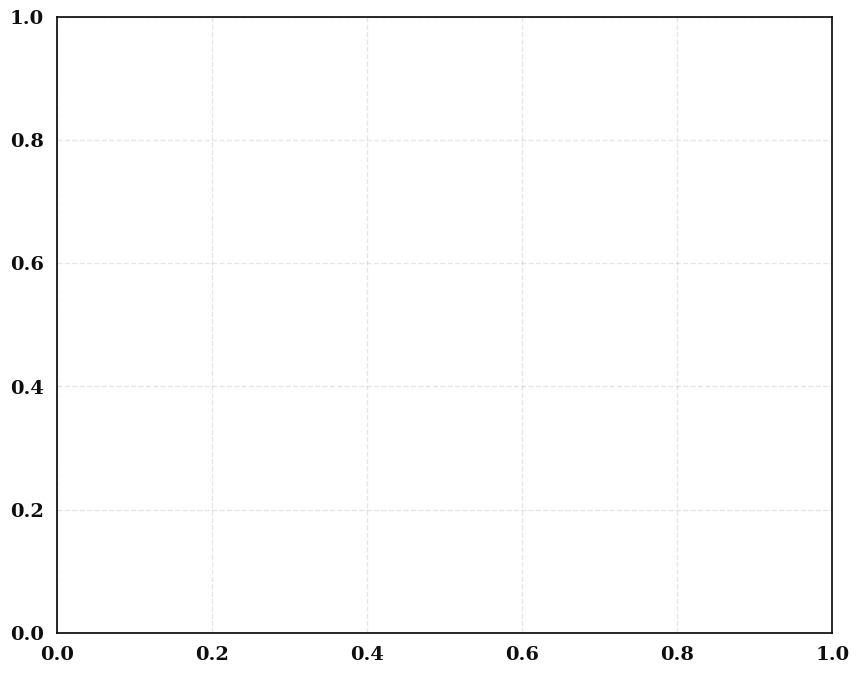

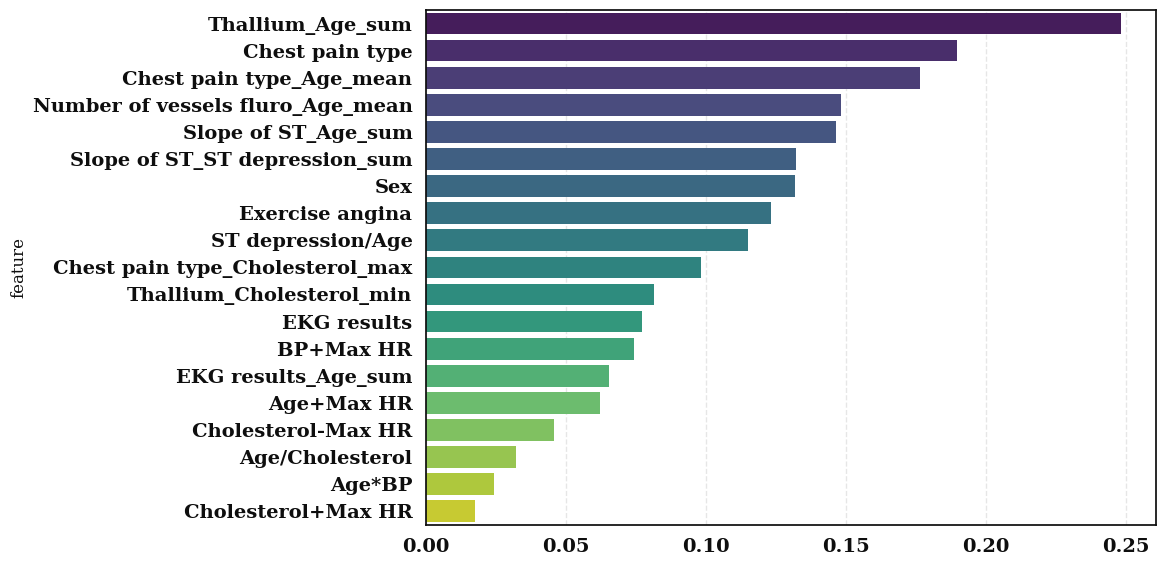

In [23]:
mic = mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(10, 8))

mi = pd.DataFrame(
    {"feature": X.columns, 
     "Mutual Information": mic}
).set_index("feature")["Mutual Information"].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=mi.values, 
    y=mi.index,
    orient="h",
    palette="viridis",
    edgecolor="none",
    linewidth=0
)

plt.tight_layout()
plt.show()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Model">
    ✨ Model
  </h1>
</div>

In [24]:
console = Console()

class Processor:
    def __init__(self, X, y, test, models):
        self.oof_train = pd.DataFrame()
        self.oof_test = pd.DataFrame()
        self.val_scores = pd.DataFrame()
        
        self.X = X
        self.y = y
        self.test = test
        self.models = models

        self.cv = StratifiedKFold(
            n_splits=cfg.splits, 
            shuffle=cfg.shuffle, 
            random_state=cfg.seed
        )
        
    def process(self):
        for name, model in self.models:
            console.print(f"\n[bold blue]Model:[/bold blue] [cyan]{name}[/cyan]")
            self.cross_val_score(name, model)
            console.print(f"[bold green]Finished {name}[/bold green]\n" + "—" * 40)
    
    def cross_val_score(self, name, model):
        oof_tr = np.zeros(self.X.shape[0])
        oof_tt = np.zeros(self.test.shape[0])
        scores = []
        
        
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(self.X, self.y)):
            X_tr, y_tr = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            
            probs_val = model.predict_proba(X_val)[:, 1]
            oof_tr[val_idx] = probs_val
            oof_tt += model.predict_proba(self.test)[:, 1] / cfg.splits
            
            fold_score = roc_auc_score(y_val, probs_val)
            scores.append(fold_score)
            
            console.print(f"[dim]Fold {fold+1}: {fold_score:.4f}[/dim]")
            
        self.oof_train[name] = oof_tr
        self.oof_test[name] = oof_tt
        self.val_scores[name] = scores
        
        console.print(f"[bold orange]>>> {name} AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}[/bold orange]\n")

In [25]:
models = [
    ('hgb', Pipeline([
        ('model', HistGradientBoostingClassifier(
            **{'random_state':cfg.seed, 
               'max_iter': 615, 
               'max_depth': 15, 
               'learning_rate': 0.0849421325741134, 
               'l2_regularization': 0.26610703720676765, 
               'min_samples_leaf': 9, 
               'max_bins': 191}))
        ])
    ),
    (
        "LGBM",
        Pipeline([
            ("model", LGBMClassifier(
                objective="binary",
                metric="auc",
                verbosity=-1,
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "XGBoost",
        Pipeline([
            ("model", XGBClassifier(
                objective="binary:logistic",
                eval_metric="auc",
                verbosity=0,
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "CatBoost",
        Pipeline([
            ("model", CatBoostClassifier(
                objective="Logloss",
                eval_metric="AUC",
                verbose=0,
                random_state=cfg.seed,
            ))
        ])
    ),
    (
        "Logistic",
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    )
]

In [26]:
stack = Processor(X, y, test, models)
stack.process()

Model: hgb

Fold 1: 0.9514

Fold 2: 0.9546

Fold 3: 0.9541

Fold 4: 0.9535

Fold 5: 0.9533

Fold 6: 0.9523

Fold 7: 0.9524

Fold 8: 0.9535

Fold 9: 0.9550

Fold 10: 0.9524

Fold 11: 0.9534

Fold 12: 0.9538

Fold 13: 0.9525

Fold 14: 0.9545

Fold 15: 0.9538

>>> hgb AUC: 0.95338 ± 0.00098

Finished hgb
————————————————————————————————————————

Model: LGBM

Fold 1: 0.9513

Fold 2: 0.9546

Fold 3: 0.9540

Fold 4: 0.9534

Fold 5: 0.9533

Fold 6: 0.9522

Fold 7: 0.9523

Fold 8: 0.9534

Fold 9: 0.9548

Fold 10: 0.9524

Fold 11: 0.9534

Fold 12: 0.9538

Fold 13: 0.9524

Fold 14: 0.9544

Fold 15: 0.9537

>>> LGBM AUC: 0.95330 ± 0.00098

Finished LGBM
————————————————————————————————————————

Model: XGBoost

Fold 1: 0.9509

Fold 2: 0.9544

Fold 3: 0.9537

Fold 4: 0.9531

Fold 5: 0.9531

Fold 6: 0.9516

Fold 7: 0.9520

Fold 8: 0.9531

Fold 9: 0.9547

Fold 10: 0.9520

Fold 11: 0.9532

Fold 12: 0.9535

Fold 13: 0.9521

Fold 14: 0.9543

Fold 15: 0.9534

>>> XGBoost AUC: 0.95300 ± 0.00105

Finished XGBoost
————————————————————————————————————————

Model: CatBoost

Fold 1: 0.9517

Fold 2: 0.9548

Fold 3: 0.9544

Fold 4: 0.9537

Fold 5: 0.9535

Fold 6: 0.9526

Fold 7: 0.9526

Fold 8: 0.9538

Fold 9: 0.9553

Fold 10: 0.9524

Fold 11: 0.9538

Fold 12: 0.9540

Fold 13: 0.9529

Fold 14: 0.9549

Fold 15: 0.9539

>>> CatBoost AUC: 0.95362 ± 0.00099

Finished CatBoost
————————————————————————————————————————

Model: Logistic

Fold 1: 0.9509

Fold 2: 0.9541

Fold 3: 0.9533

Fold 4: 0.9531

Fold 5: 0.9529

Fold 6: 0.9513

Fold 7: 0.9518

Fold 8: 0.9528

Fold 9: 0.9543

Fold 10: 0.9517

Fold 11: 0.9528

Fold 12: 0.9531

Fold 13: 0.9517

Fold 14: 0.9536

Fold 15: 0.9527

>>> Logistic AUC: 0.95267 ± 0.00096

Finished Logistic
————————————————————————————————————————

In [27]:
oof_train = stack.oof_train.copy()
oof_test = stack.oof_test.copy()

In [28]:
# Checkout: https://github.com/Matt-OP/hillclimbers
# and https://www.kaggle.com/competitions/playground-series-s3e14/writeups/matt-op-4th-place-solution-introducing-hillclimber
final_test_preds = climb_hill(
    train=train,
    oof_pred_df=oof_train,
    test_pred_df=oof_test,
    target="Heart Disease",
    objective="maximize",
    
    eval_metric=partial(roc_auc_score),
    precision=0.001,
    plot_hill=False,
    return_oof_preds=False
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

CatBoost: 0.95362 (best solo model)
hgb:      0.95338
LGBM:     0.95330
XGBoost:  0.95300
Logistic: 0.95267

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: LGBM | Best weight: 0.355 | Best roc_auc_score: 0.95378
Iteration: 2 | Model added: Logistic | Best weight: 0.109 | Best roc_auc_score: 0.95380
Iteration: 3 | Model added: XGBoost | Best weight: 0.122 | Best roc_auc_score: 0.95382
Iteration: 4 | Model added: hgb | Best weight: 0.016 | Best roc_auc_score: 0.95382


In [29]:
sub["Heart Disease"] = final_test_preds

sub.to_csv('submission.csv', index=False)

In [30]:
sub.head()

,id,Heart Disease
0,630000,0.955206
1,630001,0.115341
2,630002,0.987801
3,630003,0.105289
4,630004,0.270448
